# Locust Prediction Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../data/nasa_dataset_v0_full.csv", index_col=0)
data.head()

,date,lat_bucket_id,lon_bucket_id,Unnamed: 0.1,x,y,presence,year,month,day,...,SoilMoi10_40cm_inst_86,SoilMoi10_40cm_inst_87,SoilMoi10_40cm_inst_88,SoilMoi10_40cm_inst_89,SoilMoi10_40cm_inst_90,SoilMoi10_40cm_inst_91,SoilMoi10_40cm_inst_92,SoilMoi10_40cm_inst_93,SoilMoi10_40cm_inst_94,SoilMoi10_40cm_inst_95
0,2000-11-27,436,664,1,-13.899444,19.156944,1,2000,11,27,...,67.015625,67.230621,67.496002,67.826996,68.244873,68.757751,69.410629,70.233627,71.263626,72.536621
1,2000-11-27,436,664,2,-13.910278,19.144444,1,2000,11,27,...,67.015625,67.230621,67.496002,67.826996,68.244873,68.757751,69.410629,70.233627,71.263626,72.536621
2,2000-11-27,436,664,3,-13.923056,19.146667,1,2000,11,27,...,67.015625,67.230621,67.496002,67.826996,68.244873,68.757751,69.410629,70.233627,71.263626,72.536621
3,2000-11-28,436,668,4,-12.945833,19.146389,1,2000,11,28,...,65.580627,65.858994,66.182617,66.567749,67.029999,67.595627,68.282242,69.129501,70.175125,71.466125
4,2000-11-28,436,668,5,-12.949722,19.133056,1,2000,11,28,...,65.580627,65.858994,66.182617,66.567749,67.029999,67.595627,68.282242,69.129501,70.175125,71.466125


In [3]:
# Add surface temperature
# observation_date is encoded as year, month, day, separately
# What is "Unnamed: 0.1" Looks like indices?
# What are "dekad1_0_10"? Rename?
# Pseudo absence labels missing?
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16995 entries, 0 to 16994
Data columns (total 120 columns):
date                      object
lat_bucket_id             int64
lon_bucket_id             int64
Unnamed: 0.1              int64
x                         float64
y                         float64
presence                  int64
year                      int64
month                     int64
day                       int64
country                   object
dekad1_0_10               float64
dekad1_10_40              float64
dekad2_0_10               float64
dekad2_10_40              float64
dekad3_0_10               float64
dekad3_10_40              float64
clay_0.5cm_mean           float64
clay_5.15cm_mean          float64
sand_0.5cm_mean           float64
sand_5.15cm_mean          float64
silt_0.5cm_mean           float64
silt_5.15cm_mean          float64
observation_date          object
SoilMoi10_40cm_inst_0     float64
SoilMoi10_40cm_inst_1     float64
SoilMoi10_40cm_inst_2  

In [4]:
# Check for NAN values
nans = data.isnull().sum()
# list(zip(nans.keys(), nans.values, data.dtypes))

In [5]:
# Fill NAN values with median
for col in data.columns:
    n = pd.isnull(data[col]).sum()
    if n:
        m = data[col].median()
        # print(f"Column {col} missing {n} values. Filling with {m}")
        data[col] = data[col].fillna(m)
        
assert not data.isnull().sum().sum()

In [6]:
target = data.presence
data = data.drop(columns=["observation_date", "date", "Unnamed: 0.1", "presence", "country"])

In [7]:
np.histogram(target, 2)

(array([8473, 8522]), array([0. , 0.5, 1. ]))

## Modelling

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [9]:
def evaluate(trues, preds):
    labels = ['absence', 'presence']
    results = {}
    results['accuracy'] = metrics.accuracy_score(trues, preds)
    results['confusion_matrix'] = metrics.confusion_matrix(trues, preds)
    results['kappa'] = metrics.cohen_kappa_score(trues, preds)
    results['f1'] = metrics.f1_score(trues, preds)
    
    print(metrics.classification_report(trues, preds, target_names=labels))
    return results

In [10]:
# Probably should split data sooner
seed = 111
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.2, random_state=seed)

## Logistic Regression

In [11]:
# Scale the dataset
scaler = preprocessing.MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x)
val_x_scaled = scaler.transform(val_x)

In [12]:
model = LogisticRegression()
model.fit(train_x_scaled, train_y);

/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
y_preds = model.predict(val_x_scaled)
logistic_results = evaluate(val_y, y_preds)

              precision    recall  f1-score   support

     absence       0.90      0.80      0.84      1698
    presence       0.82      0.91      0.86      1701

    accuracy                           0.85      3399
   macro avg       0.86      0.85      0.85      3399
weighted avg       0.86      0.85      0.85      3399



In [14]:
logistic_results

{'accuracy': 0.852603706972639,
 'confusion_matrix': array([[1350,  348],
        [ 153, 1548]]),
 'kappa': 0.7051773273977491,
 'f1': 0.8607172643869891}

In [15]:
# Feature importance
weights = model.coef_[0].tolist()
features = list(zip(weights, data.columns))
list(sorted(features, key=lambda x: abs(x[0]), reverse=True))[:10]

[(-4.239130155074375, 'dekad3_0_10'),
 (-3.983337239529381, 'lon_bucket_id'),
 (-3.1299099313734904, 'x'),
 (2.893073174185937, 'dekad3_10_40'),
 (1.8404532683464463, 'SoilMoi10_40cm_inst_0'),
 (1.6922197323534907, 'sand_5.15cm_mean'),
 (1.6255759838539716, 'SoilMoi10_40cm_inst_1'),
 (1.3699330762259976, 'dekad1_10_40'),
 (-1.2668391677563189, 'SoilMoi10_40cm_inst_29'),
 (1.1996034128489994, 'dekad2_10_40')]

### XGBoost

In [16]:
train_xgb = xgb.DMatrix(train_x, label=train_y)
val_xgb = xgb.DMatrix(val_x, label=val_y)
# evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [17]:
params = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
model = xgb.train(params, train_xgb)
y_preds = model.predict(val_xgb).round(0)

[13:31:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [18]:
xgb_results = evaluate(val_y, y_preds)

              precision    recall  f1-score   support

     absence       0.91      0.88      0.90      1698
    presence       0.88      0.91      0.90      1701

    accuracy                           0.90      3399
   macro avg       0.90      0.90      0.90      3399
weighted avg       0.90      0.90      0.90      3399



In [19]:
xgb_results

{'accuracy': 0.8967343336275375,
 'confusion_matrix': array([[1496,  202],
        [ 149, 1552]]),
 'kappa': 0.7934628214589721,
 'f1': 0.8984081041968163}

#### Feature Importance

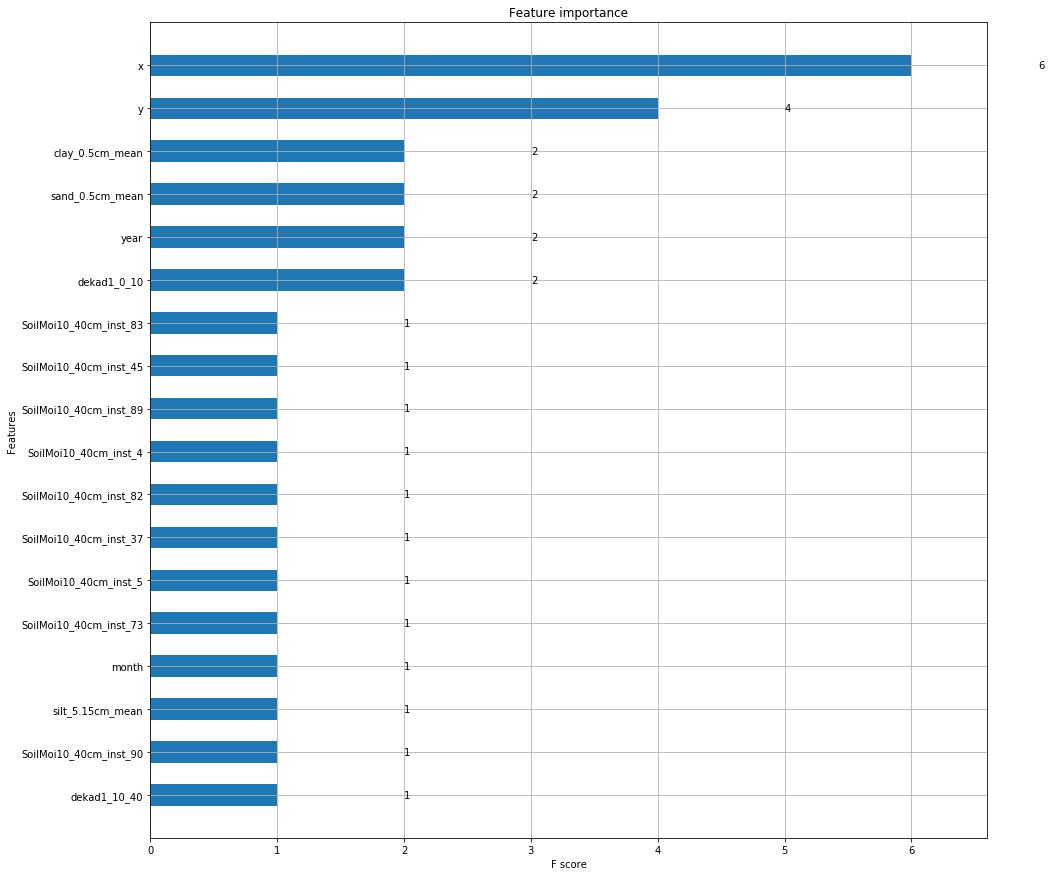

In [20]:
f,a = plt.subplots(figsize=(15,15))
xgb.plot_importance(model, height=0.5, figure=f, ax=a)

### Random Forest

In [21]:
model = RandomForestClassifier()
model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
y_preds = model.predict(val_x)
y_probs = model.predict_proba(val_x)

In [23]:
rf_results = evaluate(val_y, y_preds)

              precision    recall  f1-score   support

     absence       0.97      0.95      0.96      1698
    presence       0.95      0.97      0.96      1701

    accuracy                           0.96      3399
   macro avg       0.96      0.96      0.96      3399
weighted avg       0.96      0.96      0.96      3399



In [24]:
rf_results

{'accuracy': 0.9596940276551927,
 'confusion_matrix': array([[1614,   84],
        [  53, 1648]]),
 'kappa': 0.9193866946836174,
 'f1': 0.9600932129332944}

## Interpretation